<a href="https://colab.research.google.com/github/Alex-Jung-HB/0715_python_YOLOv8_1_image/blob/main/0715_python_YOLOv8_1_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ultralytics installing for YOLO

In [1]:
!pip install ultralytics    # pip:the standard package installer for Python
from google.colab import files
from ultralytics import YOLO    # COCO 사전 훈련된 YOLOv8n 모델 로드
model = YOLO("yolov8n.pt")    # 모델 정보 표시 (선택사항)
model.info()    # YOLOv8 모델의 상세 정보를 출력
'''
model_n.info(): 가장 가벼운 모델
model_s.info(): 중간 크기
model_m.info(): 더 큰 모델
'''
results = model.train(data="coco8.yaml", epochs=10, imgsz=640)    # coco8의 데이터를 이용하여 학습한 결과 저장
'''
data="coco8.yaml": COCO8은 COCO 데이터셋의 축소 버전
  - 8개 이미지만 포함(테스트용)
  - 80개 클래스 모두 포함
  - 빠른 테스트/데모용)
epochs: 전체 데이터셋을 한 번 학습하는 단위
  - epochs=1   매우 빠름, 성능 낮음
  - epochs=10  테스트용 (현재 설정)
  - epochs=100 일반적인 학습
  - epochs=300 고성능 학습
imgsz=640: 입력 이미지 크기 (픽셀)
  - imgsz=320  빠름, 정확도 낮음
  - imgsz=640  표준 (현재 설정)
  - imgsz=1280 느림, 정확도 높음
'''

uploaded = files.upload()
image_path = list(uploaded.keys())[0]   # dict_keys를 리스트로 변환. uploaded.keys(): 업로드된 파일명들을 반환
results = model(image_path)   # YOLOv8 모델이 이미지에서 객체 탐지(추론)를 실행. 입력된 이미지를 학습된 모델에서 처리한 뒤 결과로 도출
results[0].show()

KeyboardInterrupt: 

Improved codes to detect tiny objects such as traffic lights generatng by Gemini

In [ ]:
# 1. Ultralytics 라이브러리 설치 및 임포트
!pip install ultralytics matplotlib opencv-python numpy

from google.colab import files
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import gc

print("라이브러리 설치 및 임포트 완료!")

# 2. YOLOv8 모델 로드 (메모리 절약을 위해 yolov8m.pt 사용)
try:
    model = YOLO("yolov8m.pt") # 모델 변경: yolov8x.pt -> yolov8m.pt
    print("\nYOLOv8m 모델 로드 완료!")
    model.info()
except Exception as e:
    print(f"모델 로드 중 오류 발생: {e}")
    print("인터넷 연결을 확인하거나, 잠시 후 다시 시도해 주세요.")
    exit()

# 3. 모델 학습 (Training) - 메모리 절약을 위해 imgsz와 batch 크기 조절
print("\n모델 학습을 시작합니다. (테스트용: coco8.yaml, epochs=100, imgsz=960, batch=4)")
print("실제 사용 시에는 더 많은 에포크와 실제 도로 상황 데이터셋이 필요합니다.")
try:
    results_train = model.train(
        data="coco8.yaml", # 실제 데이터셋 경로로 변경 필요
        epochs=100,
        imgsz=960,        # 이미지 크기 변경: 1280 -> 960
        batch=4,          # 배치 크기 명시적 설정
        patience=50,
        val=True
    )
    print("\n모델 학습 완료!")
    del results_train
    gc.collect()
except Exception as e:
    print(f"모델 학습 중 오류 발생: {e}")
    print("GPU 메모리가 부족하거나, 데이터셋 경로가 잘못되었을 수 있습니다.")
    exit()

# 4. 이미지 업로드 및 추론
print("\n객체 탐지를 위한 이미지를 업로드해주세요.")
uploaded = None
try:
    uploaded = files.upload()
except Exception as e:
    print(f"파일 업로드 중 오류 발생: {e}")
    print("Colab 환경에서 파일 업로드 인터페이스가 제대로 작동하는지 확인해주세요.")

if not uploaded:
    print("이미지 업로드가 취소되었거나 파일이 선택되지 않았습니다. 프로그램이 종료됩니다.")
else:
    image_path = list(uploaded.keys())[0]
    print(f"이미지 '{image_path}' 업로드 완료.")

    # 5. 모델 추론 (Inference)
    print("\n업로드된 이미지에 대해 객체 탐지를 시작합니다...")
    try:
        # 추론 시에도 imgsz를 학습 시와 동일하게 설정
        inference_results = model(image_path, imgsz=960, conf=0.25)
        print("객체 탐지 완료!")

        # 6. 결과 시각화 (사용자 정의 시각화 부분)
        if inference_results and len(inference_results) > 0:
            # 원본 이미지 로드 (OpenCV는 BGR 순서로 읽음)
            img = cv2.imread(image_path)
            if img is None:
                print(f"이미지 로드 실패: {image_path}")
                exit()

            # 추론 결과를 반복하며 바운딩 박스와 텍스트 직접 그리기
            for r in inference_results:
                boxes = r.boxes # DetectronResult 객체에서 Boxes 추출

                for box in boxes:
                    # 바운딩 박스 좌표 추출 (x1, y1, x2, y2)
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf = box.conf[0].item() # 신뢰도
                    cls = int(box.cls[0].item()) # 클래스 ID
                    name = model.names[cls] # 클래스 이름

                    # 바운딩 박스 색상 (B, G, R) - 예: 초록색
                    color = (0, 255, 0) # Green

                    # 박스 그리기
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    # 텍스트 내용
                    label = f'{name} {conf:.2f}'

                    # 폰트 설정
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.5 # 글씨 크기 조절 (기본 0.5, 더 작게 하려면 0.3 등)
                    font_thickness = 1 # 글씨 두께

                    # 텍스트 크기 계산 (배경 사각형을 그리기 위함)
                    (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, font_thickness)

                    # 텍스트 위치 (박스 위에)
                    text_x = x1
                    text_y = y1 - 10 # 박스 위 10픽셀 위로

                    # 텍스트 배경 사각형 (투명하게 만들기 위해 그리지 않음)
                    # cv2.rectangle(img, (text_x, text_y - text_height - baseline),
                    #               (text_x + text_width, text_y + baseline),
                    #               (0, 0, 0), -1) # 검은색 배경, 채우기

                    # 텍스트 그리기
                    # (색상: 흰색, 배경 없음)
                    cv2.putText(img, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)


            # BGR을 RGB로 변환하여 Matplotlib으로 표시
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(12, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title('YOLOv8 Object Detection Results (Custom Visualization)')
            plt.show()

        else:
            print("탐지된 객체가 없거나 추론 결과가 유효하지 않습니다.")

    except Exception as e:
        print(f"모델 추론 또는 결과 시각화 중 오류 발생: {e}")
        print("이미지 파일이 손상되었거나, 모델이 제대로 로드되지 않았을 수 있습니다.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

100%|██████████| 49.7M/49.7M [00:00<00:00, 135MB/s]



YOLOv8m 모델 로드 완료!
YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs

모델 학습을 시작합니다. (테스트용: coco8.yaml, epochs=100, imgsz=960, batch=4)
실제 사용 시에는 더 많은 에포크와 실제 도로 상황 데이터셋이 필요합니다.
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco8.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=

100%|██████████| 433k/433k [00:00<00:00, 10.3MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 2724.07file/s]

Dataset download success ✅ (0.3s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 15.8MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              


  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384, 576, 3, 2]              
  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/datasets/coco8/labels/train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 66.08it/s]

train: New cache created: /content/datasets/coco8/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 965.1±273.0 MB/s, size: 54.0 KB)


val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 24036.13it/s]

val: New cache created: /content/datasets/coco8/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G     0.6974      2.346      1.218         27        960: 100%|██████████| 1/1 [01:00<00:00, 60.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:20<00:00, 20.24s/it]

                   all          4         17      0.817       0.82      0.907      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G     0.9041      2.182      1.416         22        960: 100%|██████████| 1/1 [00:56<00:00, 56.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.40s/it]

                   all          4         17      0.824      0.818      0.907      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G     0.8455      2.125      1.284         26        960: 100%|██████████| 1/1 [00:55<00:00, 55.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.49s/it]

                   all          4         17      0.829      0.813      0.901      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.086      2.146      1.755         28        960: 100%|██████████| 1/1 [00:59<00:00, 59.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.66s/it]

                   all          4         17      0.837      0.808      0.901       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.222       2.53      1.813         23        960: 100%|██████████| 1/1 [00:55<00:00, 55.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.52s/it]

                   all          4         17      0.837      0.808      0.901       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.9876      2.932      1.519         23        960: 100%|██████████| 1/1 [00:56<00:00, 56.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.92s/it]

                   all          4         17      0.844      0.807      0.903       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.8705      1.766      1.287         35        960: 100%|██████████| 1/1 [00:52<00:00, 52.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.40s/it]

                   all          4         17      0.844      0.807      0.903       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.8854       1.42      1.356         33        960: 100%|██████████| 1/1 [00:54<00:00, 54.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.15s/it]

                   all          4         17      0.839      0.809      0.903      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.117      1.306      1.586         19        960: 100%|██████████| 1/1 [00:52<00:00, 52.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.40s/it]

                   all          4         17      0.839      0.809      0.903      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.9666      1.431      1.441         30        960: 100%|██████████| 1/1 [00:55<00:00, 55.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.42s/it]

                   all          4         17      0.834      0.815      0.896      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G       1.12      3.021       1.68         24        960: 100%|██████████| 1/1 [00:54<00:00, 54.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.63s/it]

                   all          4         17      0.834      0.815      0.896      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.184      1.846       1.63         16        960: 100%|██████████| 1/1 [00:56<00:00, 56.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.27s/it]

                   all          4         17      0.834      0.815      0.896      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.126        1.6      1.645         39        960: 100%|██████████| 1/1 [00:54<00:00, 54.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.51s/it]

                   all          4         17      0.823      0.824      0.886      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.282      1.425      1.876         23        960: 100%|██████████| 1/1 [00:53<00:00, 53.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.50s/it]

                   all          4         17      0.823      0.824      0.886      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.8236      1.205      1.395         22        960: 100%|██████████| 1/1 [00:56<00:00, 56.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.65s/it]

                   all          4         17      0.823      0.824      0.886      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G       1.14      1.942      1.567         24        960: 100%|██████████| 1/1 [00:54<00:00, 54.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.37s/it]

                   all          4         17      0.765      0.842      0.889       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.038      1.817        1.6         18        960: 100%|██████████| 1/1 [00:55<00:00, 55.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.48s/it]

                   all          4         17      0.765      0.842      0.889       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]

다수의 이미지 동시 처리

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco8.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 846.3±294.0 MB/s, size: 54.0 KB)



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

Plotting labels to runs/detect/train8/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train8
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.082      1.853      1.368         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all          4         17      0.634       0.87      0.888      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.9278      3.138      1.165         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all          4         17      0.703      0.833      0.888      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.9953      2.825      1.309         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          4         17      0.725      0.831      0.889      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.235      2.602      1.454         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         17      0.629      0.833      0.873      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.8402      2.598      1.306         13        640: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          4         17      0.683      0.833      0.873      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.049      2.406      1.444         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          4         17      0.709       0.75      0.879      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.268       2.48       1.46         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all          4         17      0.767      0.743      0.879      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.8933      1.874      1.264         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all          4         17      0.741       0.75      0.893      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.9484       1.66      1.182         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         17      0.729       0.75      0.877       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7684      1.957       1.22         13        640: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          4         17      0.717       0.75      0.778      0.594



10 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 6.5MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


                   all          4         17      0.633      0.871      0.888      0.624
                person          3         10      0.696        0.5       0.52      0.279
                   dog          1          1      0.398          1      0.995      0.597
                 horse          1          2      0.749          1      0.995      0.598
              elephant          1          2      0.574      0.723      0.828      0.381
              umbrella          1          1      0.566          1      0.995      0.995
          potted plant          1          1      0.817          1      0.995      0.895
Speed: 2.3ms preprocess, 224.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train8


Saving baby.jpg to baby (5).jpg
Saving building.jpg to building (5).jpg
Saving earth.jpg to earth (5).jpg
Saving pineapple.jpg to pineapple (5).jpg
Saving plains-zebra.webp to plains-zebra (5).webp
Saving rabit.webp to rabit (5).webp
Saving robot.jpg to robot (5).jpg
Saving watermallon.jpg to watermallon (5).jpg
Saving 저스틴비버.jpg to 저스틴비버 (5).jpg
Saving 페라리.jpg to 페라리 (5).jpg

0: 640x640 1 person, 214.6ms
1: 640x640 (no detections), 214.6ms
2: 640x640 (no detections), 214.6ms
3: 640x640 1 vase, 214.6ms
4: 640x640 1 zebra, 214.6ms
5: 640x640 1 bear, 214.6ms
6: 640x640 (no detections), 214.6ms
7: 640x640 1 orange, 1 broccoli, 214.6ms
8: 640x640 1 person, 214.6ms
9: 640x640 1 car, 214.6ms
Speed: 4.1ms preprocess, 214.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

--- Result for Image 1: baby (5).jpg ---


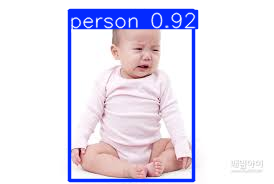


--- Result for Image 2: building (5).jpg ---


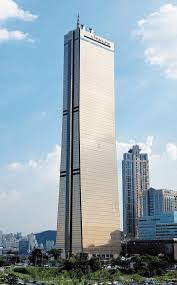


--- Result for Image 3: earth (5).jpg ---


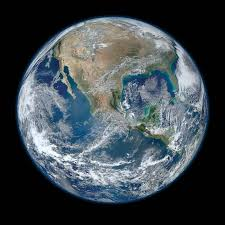


--- Result for Image 4: pineapple (5).jpg ---


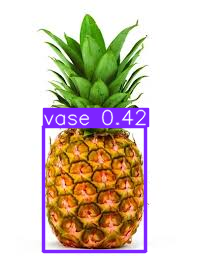


--- Result for Image 5: plains-zebra (5).webp ---


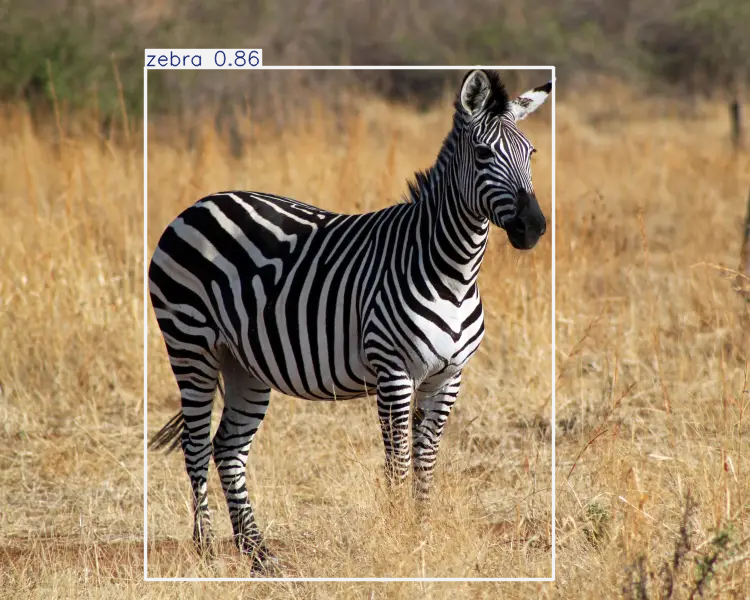


--- Result for Image 6: rabit (5).webp ---


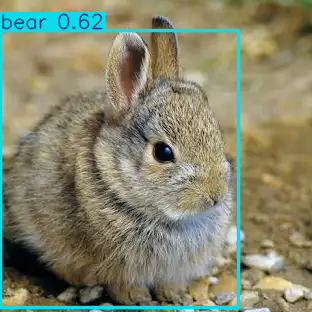


--- Result for Image 7: robot (5).jpg ---


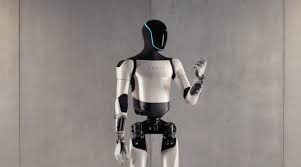


--- Result for Image 8: watermallon (5).jpg ---


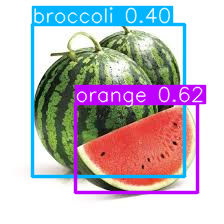


--- Result for Image 9: 저스틴비버 (5).jpg ---


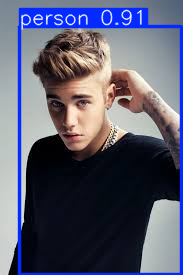


--- Result for Image 10: 페라리 (5).jpg ---


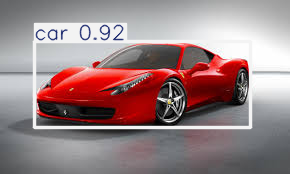

In [ ]:
!pip install ultralytics    # pip:the standard package installer for Python
from google.colab import files
from ultralytics import YOLO    # COCO 사전 훈련된 YOLOv8n 모델 로드
model = YOLO("yolov8n.pt")    # 모델 정보 표시 (선택사항)
model.info()    # YOLOv8 모델의 상세 정보를 출력
results = model.train(data="coco8.yaml", epochs=10, imgsz=640)    # coco8의 데이터를 이용하여 학습한 결과 저장

# Upload multiple images
uploaded = files.upload()
all_image_paths = list(uploaded.keys())   # 다수의 이미지로 변수수정

# Process all images at once (more efficient)
results = model(all_image_paths)  # Pass list of paths    # 다수의 입력된 이미지를 모두 처리하도록 수정

# Show results for each image
for i, result in enumerate(results):    # 입력된 이미지에 순번매김
    print(f"\n--- Result for Image {i+1}: {all_image_paths[i]} ---")    # 번호를 1씩 올려가면서 출력이미지에 대한 메세지 출력
    result.show()

출력된 그림을 2행 5열로 배치되도록 수정

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco8.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train9, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 558.8±140.1 MB/s, size: 54.0 KB)



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

Plotting labels to runs/detect/train9/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train9
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.082      1.853      1.368         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         17      0.634       0.87      0.888      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.9278      3.138      1.165         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          4         17      0.703      0.833      0.888      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.9953      2.825      1.309         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          4         17      0.725      0.831      0.889      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.235      2.602      1.454         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all          4         17      0.629      0.833      0.873      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.8402      2.598      1.306         13        640: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          4         17      0.683      0.833      0.873      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.049      2.406      1.444         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          4         17      0.709       0.75      0.879      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.268       2.48       1.46         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          4         17      0.767      0.743      0.879      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.8933      1.874      1.264         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          4         17      0.741       0.75      0.893      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.9484       1.66      1.182         13        640: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all          4         17      0.729       0.75      0.877       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7684      1.957       1.22         13        640: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          4         17      0.717       0.75      0.778      0.594



10 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.5MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


                   all          4         17      0.633      0.871      0.888      0.624
                person          3         10      0.696        0.5       0.52      0.279
                   dog          1          1      0.398          1      0.995      0.597
                 horse          1          2      0.749          1      0.995      0.598
              elephant          1          2      0.574      0.723      0.828      0.381
              umbrella          1          1      0.566          1      0.995      0.995
          potted plant          1          1      0.817          1      0.995      0.895
Speed: 2.3ms preprocess, 225.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train9


Saving KakaoTalk_20250704_210829744_01.jpg to KakaoTalk_20250704_210829744_01.jpg
업로드된 이미지: 1개

0: 480x640 6 cars, 1 truck, 1 traffic light, 180.5ms
Speed: 4.6ms preprocess, 180.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

📸 KakaoTalk_20250704_210829744_01.jpg:
   탐지된 객체: 8개
     - car: 0.87
     - car: 0.85
     - car: 0.79
     - truck: 0.77
     - car: 0.60
     - car: 0.58
     - traffic light: 0.36
     - car: 0.32


/tmp/ipython-input-37-830846666.py:83: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-830846666.py:83: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-830846666.py:83: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-830846666.py:83: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-830846666.py:83: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-830846666.py:83: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-830846666.py:83: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.ti

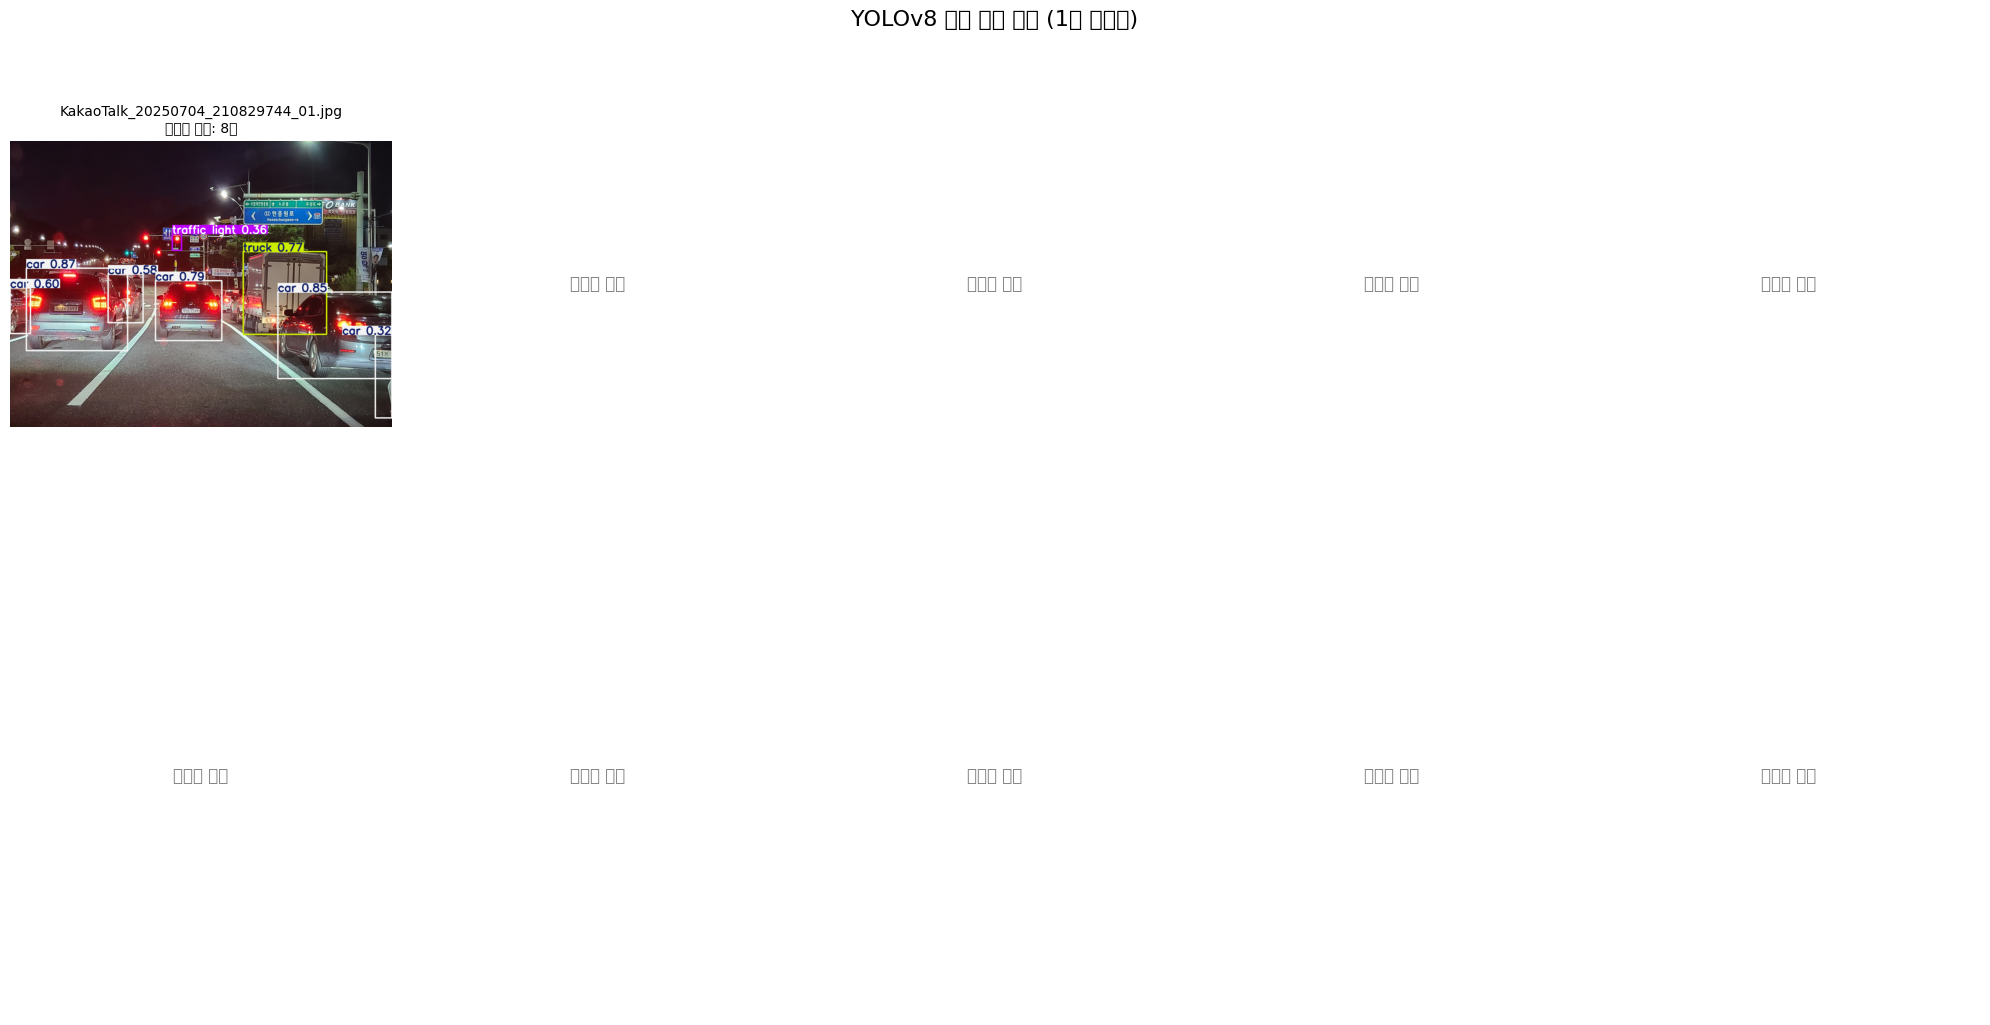

In [ ]:
!pip install ultralytics    # pip:the standard package installer for Python
!pip install opencv-python  # ← 이 줄만 추가!

from google.colab import files
from ultralytics import YOLO
import matplotlib.pyplot as plt  # 위로 이동
import cv2  # 위로 이동

model = YOLO("yolov8n.pt")    # 모델 정보 표시 (선택사항)
model.info()    # YOLOv8 모델의 상세 정보를 출력
results = model.train(data="coco8.yaml", epochs=10, imgsz=640)    # coco8의 데이터를 이용하여 학습한 결과 저장

# ========== 여기서부터 수정된 부분 ==========
uploaded = files.upload()
all_image_paths = list(uploaded.keys())   # 모든 업로드된 파일명들을 리스트로 변환
print(f"업로드된 이미지: {len(all_image_paths)}개")

# 모든 이미지에 대해 객체 탐지 실행
detection_results = model(all_image_paths)   # YOLO8이 여러 이미지를 받아 한번에 처리

# 2행 5열 그리드 설정
rows, cols = 2, 5
max_images = rows * cols  # 최대 10개 이미지
num_images = min(len(detection_results), max_images)    # 실제 표시할 이미지 개수를 결정. min(A,B): 두 개 중 작은 숫자로 결정

# Figure 생성
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 처리를 쉽게

'''
2D 배열 (flatten 전):
Grid Layout:                  axes 배열 구조:
┌──┬──┬──┬──┬──┐    [[axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]],
│   0│   1│   2│   3│   4│     [axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]]]
├──┼──┼──┼──┼──┤
│   5│   6│   7│   8│   9│    접근: axes[행][열]
└──┴──┴──┴──┴──┘

1D 배열 (flatten 후):
Grid Layout:                  axes 배열 구조:
┌──┬──┬──┬──┬──┐    [axes[0], axes[1], axes[2], axes[3], axes[4],
│   0│   1│   2│   3│   4│     axes[5], axes[6], axes[7], axes[8], axes[9]]
├──┼──┼──┼──┼──┤
│   5│   6│   7│   8│   9│    접근: axes[인덱스]
└──┴──┴──┴──┴──┘
'''

# 각 이미지 결과를 그리드에 표시
for i in range(max_images):
    if i < num_images:  # 실제 이미지가 있는 경우
        result = detection_results[i]   # i번째 이미지에 대한 처리결과 출력
        annotated_img = result.plot()   # 탐지 결과가 그려진 이미지

        # ✅ 수정: continue 로직을 먼저 처리
        if annotated_img is None:   # if - contine 문장. True --> 넘어가서 다른 이미지 확인, False --> 다음 코드로 진입(annotated_ing = ......)
            continue    # 반복문에서 현재 반복을 건너뛰고 다음 반복으로 넘어가는 Python 제어문(annotated_img가 나올 때까지 넘어가라)

        # ✅ 수정: 정상적인 이미지 처리
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)   # BGR(Blue-Green-Red) → RGB(Red-Green-Blue) 색상 순서 변환, OpenCV는 BGR 사용, matplotlib는 RGB 사용

        # 이미지 표시
        '''
        annotated_img: 바운딩 박스가 그려진 탐지 결과 이미지
        .imshow(): matplotlib에서 이미지를 표시하는 함수
        axes[i]: i번째 subplot (그리드의 특정 위치(이미지가 들어가는 칸))
        '''
        axes[i].imshow(annotated_img)
        axes[i].set_title(f'{all_image_paths[i]}\n탐지된 객체: {len(result.boxes)}개', fontsize=10)
        axes[i].axis('off')

        print(f"\n📸 {all_image_paths[i]}:")
        print(f"   탐지된 객체: {len(result.boxes)}개")
        for j, box in enumerate(result.boxes):
            class_name = result.names[int(box.cls)]
            confidence = float(box.conf)
            print(f"     - {class_name}: {confidence:.2f}")

    else:  # ✅ 수정: 올바른 들여쓰기
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, '이미지 없음', ha='center', va='center',
                    fontsize=12, color='gray', transform=axes[i].transAxes)

plt.tight_layout()
plt.suptitle(f'YOLOv8 객체 탐지 결과 ({num_images}개 이미지)', fontsize=16, y=1.02)
plt.show()